In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [233]:
df = pd.read_csv('data.csv')

In [234]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [235]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Train decision tree with default parameters

In [236]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt', DecisionTreeRegressor(random_state=42))])

In [237]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [238]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 0.000
MAE: 0.000
R2: 1.000

Test Set:
MSE: 9.372
MAE: 2.131
R2: 0.805


In [239]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.79399773 0.79941775 0.79144076 0.78148488 0.78076705]
R^2 trung bình: 0.789 ± 0.007

MSE: [10.01699164  9.64651811 10.09640568 10.32070215 10.76427974]
MSE trung bình: 10.169± 0.368

MAE: [2.14958217 2.12451253 2.14767345 2.1395932  2.16857063]
MAE trung bình: 2.146 ± 0.014


In [66]:
max_depths = np.arange(1, 21)
mse_train_values, mse_test_values = [], []
mae_train_values, mae_test_values = [], []
r2_train_values, r2_test_values = [], []

for depth in max_depths:
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(max_depth=depth))
    ])
    model.fit(X_train, y_train)
    
    mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
    mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)

    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)

    mae_train_values.append(mae_train)
    mae_test_values.append(mae_test)
    
    r2_train_values.append(r2_train)
    r2_test_values.append(r2_test)

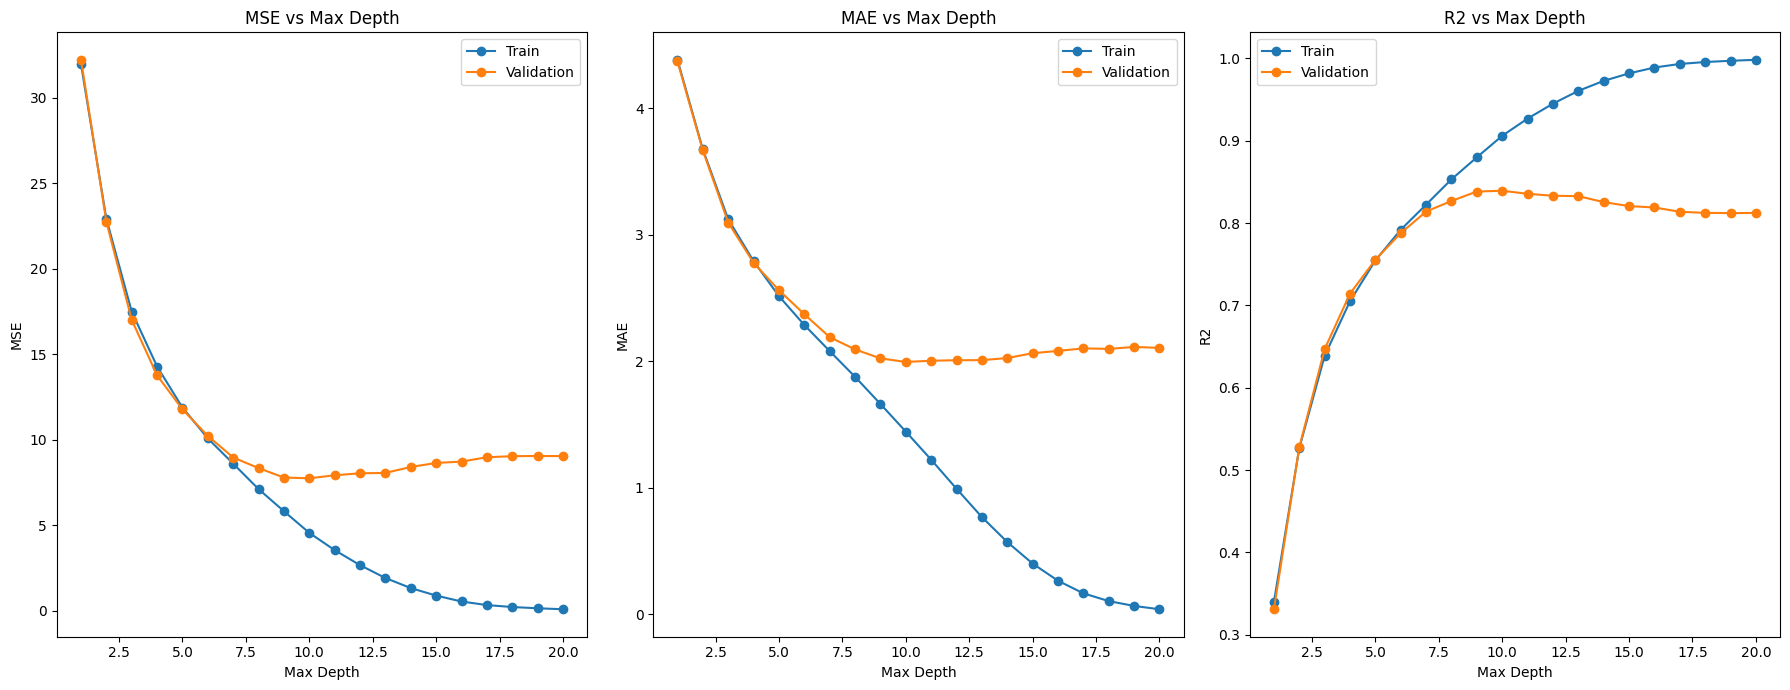

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 7))

plt.subplot(1, 3, 1)
plt.plot(max_depths, mse_train_values, label='Train', marker='o')
plt.plot(max_depths, mse_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Max Depth')

plt.subplot(1, 3, 2)
plt.plot(max_depths, mae_train_values, label='Train', marker='o')
plt.plot(max_depths, mae_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Max Depth')

plt.subplot(1, 3, 3)
plt.plot(max_depths, r2_train_values, label='Train', marker='o')
plt.plot(max_depths, r2_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.legend()
plt.title('R2 vs Max Depth')

plt.tight_layout()
plt.show()

As we can see here, the decision tree is completely fitted to our training data, leading to a "perfect" result. However, it does not perform well on the validation and test sets, which is a sign of **overfitting**. 

# Inference from plotted graph

In [10]:
k_max_depth = np.argmin(mse_test_values)
best_max_depth = max_depths[k_max_depth]
print(f'Best Max Depth: {best_max_depth}')
print(f'Train MSE: {mse_test_values[k_max_depth]:.3f}')

Best Max Depth: 10
Train MSE: 7.577


In [11]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(max_depth=best_max_depth))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt', DecisionTreeRegressor(max_depth=np.int64(10)))])

In [12]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 4.545
MAE: 1.445
R2: 0.906

Test Set:
MSE: 7.763
MAE: 2.000
R2: 0.839


# Pruning decision tree having max_depth = 13

In [95]:
import pandas as pd
df = pd.read_csv('data_encoded.csv')

In [96]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [100]:
model = DecisionTreeRegressor(random_state=42, max_depth=13)

path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1]

ccp_alphas.shape, impurities.shape

((2656,), (2656,))

In [101]:
ccp_alphas

array([0.00000000e+00, 3.98025792e-05, 3.98025792e-05, ...,
       2.44285898e+00, 2.79889466e+00, 6.60340123e+00])

In [102]:
df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [103]:
from sklearn.model_selection import cross_val_score

trees = []
scores = []

for ccp_alpha in ccp_alphas:
    tree = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha))
    ])
    tree.fit(X_train, y_train)
    trees.append(tree)

    score = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    scores.append(np.mean(score))

MSE_train = [mean_squared_error(y_train, tree.predict(X_train)) for tree in trees]
MSE_test = [mean_squared_error(y_test, tree.predict(X_test)) for tree in trees]

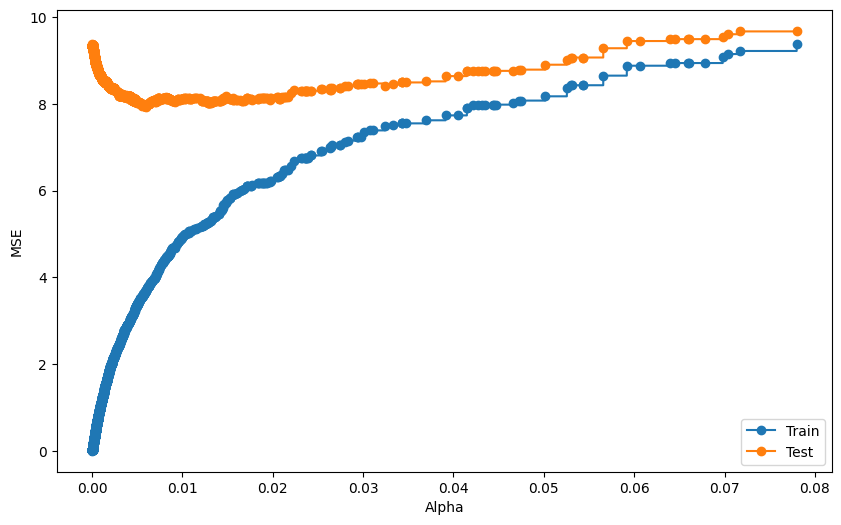

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
    
ax.plot(ccp_alphas[:2620], MSE_train[:2620], marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas[:2620], MSE_test[:2620], marker='o', label='Test', drawstyle='steps-post')

ax.legend()
plt.show()

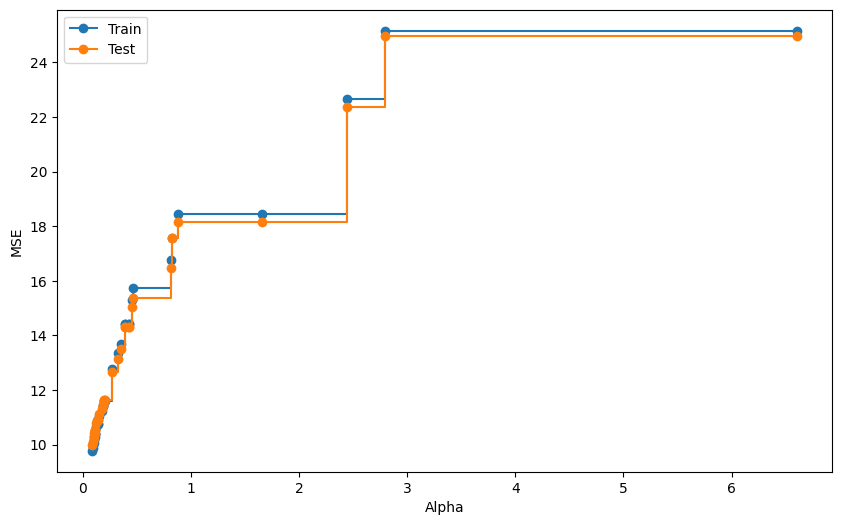

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
    
ax.plot(ccp_alphas[2620:], MSE_train[2620:], marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas[2620:], MSE_test[2620:], marker='o', label='Test', drawstyle='steps-post')

ax.legend()
plt.show()

Best alpha: 0.014447222009716376
Best MSE: 8.84037783627623


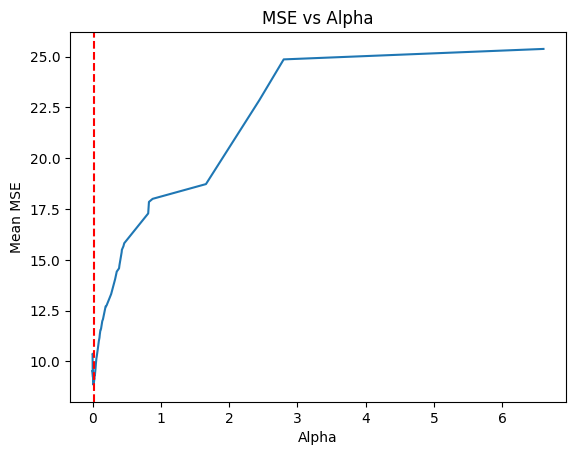

In [ ]:
scores = [-score for score in scores]

plt.plot(ccp_alphas[:], scores[:])
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.title('MSE vs Alpha')

best_idx = np.argmin(scores)
plt.axvline(x=ccp_alphas[best_idx], color='r', linestyle='--', label=f'Best Alpha: {ccp_alphas[best_idx]:.4f}')

print(f"Best alpha: {ccp_alphas[best_idx]}")
print(f"Best MSE: {scores[best_idx]}")

In [146]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alphas[best_idx]))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=np.float64(0.014447222009716376),
                                       random_state=42))])

In [147]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 5.598
MAE: 1.806
R2: 0.884

Test Set:
MSE: 8.097
MAE: 2.087
R2: 0.832


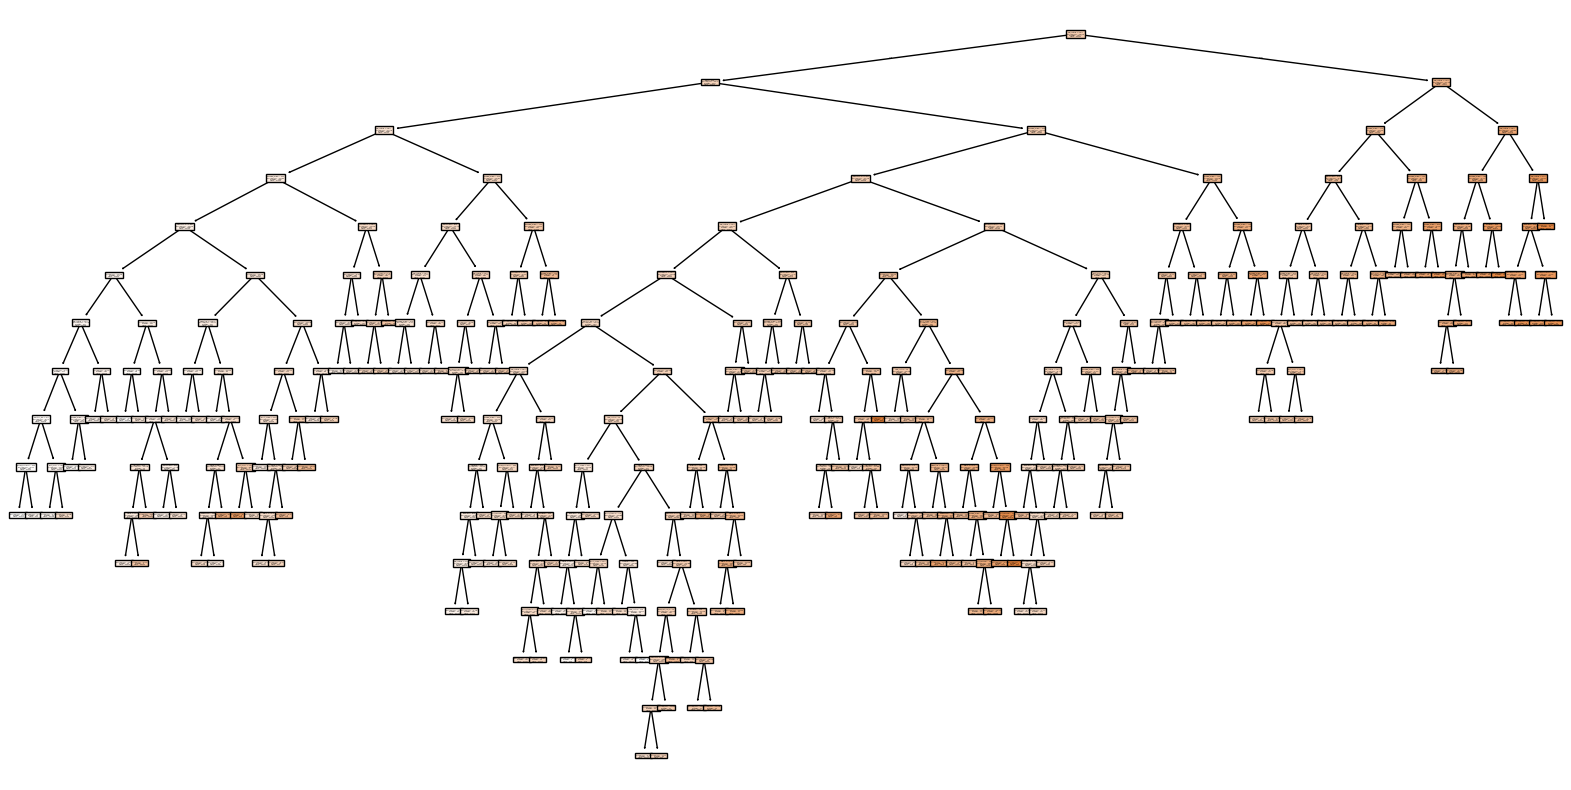

In [148]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.named_steps['dt'], filled=True, feature_names=X.columns)
plt.show()

## Cross validation to evaluate model

In [150]:
df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [153]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alphas[best_idx]))
])

In [156]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.83369975 0.83052335 0.83405555 0.81407873 0.8186762 ]
R^2 trung bình: 0.826 ± 0.008

MSE: [8.08645531 8.15056958 8.03341306 8.78126006 8.90295032]
MSE trung bình: 8.391± 0.372

MAE: [2.09266545 2.06677675 2.06806954 2.1168852  2.1415223 ]
MAE trung bình: 2.097 ± 0.029


# Genetic algorithm to find optimal decision tree

In [209]:
import pandas as pd

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [210]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [211]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [221]:
def create_individual():
    max_depth = np.random.randint(1, 30)
    min_samples_split = np.random.randint(2, 100)
    ccp_alpha = np.random.uniform(0, 0.1)
    min_samples_leaf = np.random.randint(1, 100)
    return [max_depth, min_samples_split, ccp_alpha, min_samples_leaf]

def fitness(individual):
    max_depth, min_samples_split, ccp_alpha, min_samples_leaf = individual
    
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(
            random_state=42, 
            max_depth=max_depth, 
            min_samples_split=min_samples_split,
            ccp_alpha=ccp_alpha,
            min_samples_leaf=min_samples_leaf
        ))
    ])
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean(),

def create_population(pop_size):
    return [create_individual() for _ in range(pop_size)]

def crossover(ind1, ind2):
    crossover_point = np.random.randint(0, len(ind1))
    child1 = ind1[:crossover_point] + ind2[crossover_point:]
    child2 = ind2[:crossover_point] + ind1[crossover_point:]
    return child1, child2
    # child1 = [ind1[0], ind2[1]]
    # child2 = [ind2[0], ind1[1]]
    # return child1, child2

def mutate(individual, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        mutation_point = np.random.randint(0, len(individual))
        if mutation_point == 0:
            individual[mutation_point] = np.random.randint(1, 30)
        elif mutation_point == 1:
            individual[mutation_point] = np.random.randint(2, 100)
        elif mutation_point == 2:
            individual[mutation_point] = np.random.uniform(0, 0.1)
        else:
            individual[mutation_point] = np.random.randint(1, 100)
    return individual

In [222]:
def genetic_algorithm(pop_size, generations, generations_values, fitness_values):
    population = create_population(pop_size)

    for generation in range(generations):
        scores = [fitness(ind) for ind in population]
        sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]

        print(f'Generation {generation + 1}: Best MSE: {scores[0][0]:.3f}')
        print(f'Solution: {sorted_population[0]}')

        generations_values.append(generation + 1)
        fitness_values.append(-scores[0][0])

        # Elitism
        parents = sorted_population[:10]
        # print('Parents:\n', parents)

        next_generation = parents[:]

        while len(next_generation) < pop_size:
            # Selection
            idx1 = np.random.randint(0, len(parents))
            idx2 = np.random.randint(0, len(parents))
            parent1, parent2 = parents[idx1], parents[idx2]

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_generation.append(child1)
            next_generation.append(child2)

        population = next_generation
    
    scores = [fitness(ind) for ind in population]
    sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]
    return sorted_population[0]

In [223]:
pop_size = 100
generations = 30

generation_values = []
fitness_values = []

best_individual = genetic_algorithm(pop_size, generations, generation_values, fitness_values)
best_individual

Generation 1: Best MSE: 9.580
Solution: [19, 37, 0.0016101282746356473, 12]
Generation 2: Best MSE: 8.310
Solution: [11, 37, 0.0016101282746356473, 12]
Generation 3: Best MSE: 8.247
Solution: [19, 37, 0.0016101282746356473, 17]
Generation 4: Best MSE: 8.193
Solution: [19, 37, 0.0016101282746356473, 17]
Generation 5: Best MSE: 8.193
Solution: [19, 37, 0.0016101282746356473, 17]
Generation 6: Best MSE: 8.193
Solution: [19, 37, 0.0016101282746356473, 22]
Generation 7: Best MSE: 8.163
Solution: [19, 37, 0.0016101282746356473, 22]
Generation 8: Best MSE: 8.163
Solution: [19, 37, 0.0016101282746356473, 22]
Generation 9: Best MSE: 8.163
Solution: [19, 37, 0.0016101282746356473, 22]
Generation 10: Best MSE: 8.163
Solution: [19, 37, 0.0016101282746356473, 22]
Generation 11: Best MSE: 8.163
Solution: [19, 37, 0.0016101282746356473, 15]
Generation 12: Best MSE: 8.148
Solution: [19, 37, 0.0016101282746356473, 15]
Generation 13: Best MSE: 8.148
Solution: [19, 37, 0.0016101282746356473, 15]
Generati

[17, 43, 0.0016101282746356473, 15]

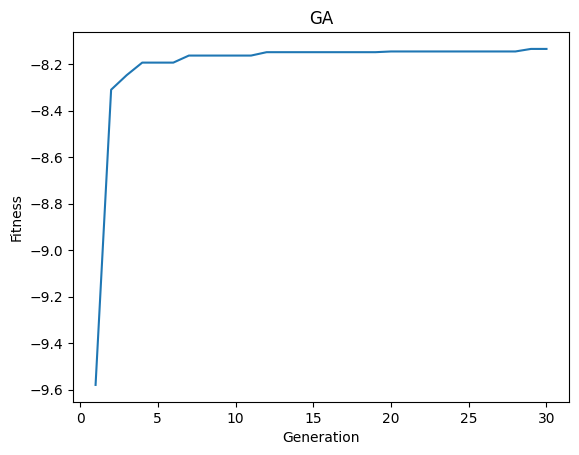

In [224]:
import matplotlib.pyplot as plt

plt.plot(generation_values, fitness_values)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('GA')
plt.show()

In [228]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(
        random_state=42, 
        max_depth=best_individual[0], 
        min_samples_split=best_individual[1],
        ccp_alpha=best_individual[2],
        min_samples_leaf=best_individual[3]
    ))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.0016101282746356473,
                                       max_depth=17, min_samples_leaf=15,
                                       min_samples_split=43,
                                       random_state=42))])

In [229]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 4.572
MAE: 1.516
R2: 0.906

Test Set:
MSE: 7.097
MAE: 1.921
R2: 0.853


In [230]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.85182939 0.85056459 0.85208406 0.83762572 0.84183376]
R^2 trung bình: 0.847 ± 0.006

MSE: [7.20489006 7.1867346  7.16064837 7.66911052 7.76592015]
MSE trung bình: 7.397± 0.263

MAE: [1.91376158 1.9245433  1.92016206 1.93300976 1.95402169]
MAE trung bình: 1.929 ± 0.014


In [232]:
# from sklearn.tree import plot_tree

# plt.figure(figsize=(20, 10))
# plot_tree(model.named_steps['dt'], filled=True, feature_names=X.columns)
# plt.show()